In [ ]:
!pip install transformers
!pip install evaluate
!pip install sentencepiece
!pip install rouge

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 708.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import T5Model, T5ForConditionalGeneration, T5TokenizerFast
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import custom module

In [ ]:
%cd /content/drive/MyDrive/ITMO/T5QA/src
%ls

/content/drive/MyDrive/ITMO/T5QA/src
medqadataset.py  __pycache__/  trainer.py


In [ ]:
from medqadataset import MedQADataset
import trainer

In [ ]:
# For debugging
# import importlib
# importlib.reload(trainer)

In [ ]:
#MODEL_NAME = "cointegrated/rut5-base"    # pre-trained model (first iteration)
MODEL_NAME = "/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel_generated2"
TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME, local_files_only=True)
#TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME)
# Set up the T5 model
MODEL = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
# Set up the optimizer
OPTIMIZER = Adam(MODEL.parameters(), lr=0.0001)
Q_LEN = 512    # Question Length
T_LEN = 128    # Target Length
BATCH_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
DEVICE

'cpu'

### Read Data

In [ ]:
PATH = '/content/drive/MyDrive/ITMO/T5QA'

data = pd.read_csv(PATH + '/data/MedQuAD_generated_concat.csv', index_col=0)
data.index = [i for i in range(len(data))]

data

,question,context,answer
0,что такое кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляе...,кератодермия с пушистыми волосами представляет...
1,сколько людей с шерстяными волосами страдают к...,кератодермия с пушистыми волосами представляе...,кератодермия с пушистыми волосами встречается ...
2,"каковы генетические изменения, связанные с кер...",кератодермия с пушистыми волосами представляе...,"мутации в генах jup, dsp, dsc2 и kank2 вызываю..."
3,передается ли кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляе...,большинство случаев кератодермии с курчавыми в...
4,что такое синдром кноблоха?,"синдром кноблоха редкое заболевание, характер...","синдром кноблоха редкое заболевание, характери..."
...,...,...,...
6401,что такое гипотония?,"g часов, а также часто нарушают сон. непроизво...",слабый мышечный тонус
6402,"какова основная причина дискинезии, связанной ...","у некоторых людей с дискинезией, связанной с a...",беспокойство
6403,"какова причина дискинезии, связанной с adcy5?","кинезия, в то время как у некоторых больных мо...",церебральный паралич или эпилепсия
6404,"какова причина дискинезии, связанной с adcy5?","название предполагает, что дискинезия, связанн...",ген adcy5


### Example

In [ ]:
sample = data.iloc[5]
encoding = TOKENIZER(
    sample["question"],
    sample["context"],
    max_length=512,
    padding="max_length",
    truncation="only_second",
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors='pt'
)

answer_encoding = TOKENIZER(
    sample["answer"],
    max_length=128,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

labels = answer_encoding["input_ids"]

output = MODEL(
    input_ids=encoding["input_ids"],
    attention_mask=encoding["attention_mask"],
    labels=labels
)

In [ ]:
output.loss

tensor(103.7389, grad_fn=<NllLossBackward0>)

In [ ]:
sample_q = data.iloc[5]["question"]
sample_a = data.iloc[5]["answer"]

sample_encoding = TOKENIZER(sample_q, sample_a)

In [ ]:
sample_encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
preds = [
    TOKENIZER.decode(input_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    for input_id in sample_encoding["input_ids"]
]

In [ ]:
" ".join(preds)

' сколько люд ей страда ет си ндром ом кн обл оха ?  си ндром кн обл оха ред кое заболевани е .  о днако  точная распростран енность это го заболевани я не известн а . '

### Dataloaders

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.02, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")
print(f"Test shape: {test_data.shape}")

train_sampler = RandomSampler(train_data.index)
val_sampler = RandomSampler(val_data.index)

qa_dataset = MedQADataset(TOKENIZER, data, Q_LEN, T_LEN)

train_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, patience=5, verbose=True)

Train shape: (5021, 3)
Validation shape: (1256, 3)
Test shape: (129, 3)


### Train and validation loop

In [ ]:
N_EPOCHS = 78
STATE_DICT_PATH = '/content/drive/MyDrive/ITMO/T5QA/checkpoints/best_model/MedQAModel_generated2'

trainer_module = trainer.Trainer(
    MODEL,
    N_EPOCHS,
    STATE_DICT_PATH,
    train_loader,
    val_loader,
    OPTIMIZER,
    DEVICE,
    TOKENIZER,
    Q_LEN,
    T_LEN,
    scheduler
)

In [ ]:
trainer_module.fit()

Validation batches: 100%|██████████| 314/314 [01:22<00:00,  3.81it/s]


Epoch: 0		Train loss: 0.2818908814762001		Validation loss: 0.1787968614749658


Validation batches: 100%|██████████| 314/314 [01:20<00:00,  3.88it/s]


Epoch: 1		Train loss: 0.25946045455948824		Validation loss: 0.15667781953782936


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 2		Train loss: 0.23667542299513028		Validation loss: 0.1304616787482741


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.88it/s]


Epoch: 3		Train loss: 0.217786382015492		Validation loss: 0.11864049406128989


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 4		Train loss: 0.20089177161923782		Validation loss: 0.10105105999940235


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 5		Train loss: 0.18302270409032506		Validation loss: 0.08018190872404653


Validation batches: 100%|██████████| 314/314 [01:20<00:00,  3.88it/s]


Epoch: 6		Train loss: 0.17108835548218165		Validation loss: 0.07002196595025291


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 7		Train loss: 0.15860131966937438		Validation loss: 0.06519367904061227


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.85it/s]


Epoch: 8		Train loss: 0.1493495378284945		Validation loss: 0.05084848739236451


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 9		Train loss: 0.14142028607194873		Validation loss: 0.045797957992774384


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.86it/s]


Epoch: 10		Train loss: 0.12760373881323245		Validation loss: 0.03953428583436165


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.85it/s]


Epoch: 11		Train loss: 0.11958530881792905		Validation loss: 0.03507206244928062


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.86it/s]


Epoch: 12		Train loss: 0.11140893732819886		Validation loss: 0.030282661705656026


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 13		Train loss: 0.10669404121726057		Validation loss: 0.02407424639312441


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.88it/s]


Epoch: 14		Train loss: 0.09961680513126027		Validation loss: 0.02668107630630101


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 15		Train loss: 0.09717303666965198		Validation loss: 0.020242632325934425


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.87it/s]


Epoch: 16		Train loss: 0.09008254343839586		Validation loss: 0.018255220738367123


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.86it/s]


Epoch: 17		Train loss: 0.08660821044985574		Validation loss: 0.01707949109513025


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.88it/s]


Epoch: 18		Train loss: 0.07870704091414397		Validation loss: 0.0160658341483213


Validation batches: 100%|██████████| 314/314 [01:21<00:00,  3.86it/s]


Epoch: 19		Train loss: 0.07697193935446252		Validation loss: 0.016137460002914415


Training batches:  66%|██████▋   | 834/1256 [09:40<04:54,  1.43it/s]

### Evaluate results

In [ ]:
test_sample = test_data.iloc[0]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"
test_answer = f"Ответ: {test_sample['answer']}"

test_question

pred = trainer_module.predict_answer(
    test_context,
    test_question,
    test_answer,
    print_text=True
)

pred

Контекст: независимо от того, кормите ли вы ребенка грудным молоком, детской смесью или и тем, и другим, вам придется покупать бутылочки и соски. у вас есть большой выбор, поэтому может быть трудно понять, что купить. узнайте о различных вариантах и ​​о том, как ухаживать за бутылочками и сосками. как выбрать бутылочку и соску. тип соски и бутылочки, которые вы выберете, в основном будет зависеть от того, какой тип будет использовать ваш ребенок. некоторые дети предпочитают определенную форму соска, или при использовании определенных бутылочек у них может выделяться меньше газов. другие менее привередливы к определенным бутылкам. начинать
Вопрос: какой тип бутылочки и соски выбрать?
Ответ: какой тип соски будет в основном зависеть от того, какой тип будет использовать ваш ребенок


{'Reference Answer: ': 'Ответ: какой тип соски будет в основном зависеть от того, какой тип будет использовать ваш ребенок',
 'Predicted Answer: ': 'Ответ: какой тип соски будет в основном зависеть от того, какой тип будет использовать ваш ребенок',
 'BLEU Score: ': {'google_bleu': 1.0},
 'RougeL (precision): ': 1.0}

In [ ]:
# Calculate metrics on test
bleu_avg, rouge_avg = trainer_module.calc_avg_metrics(test_data)
print("Test:")
print("BLEU:", bleu_avg)
print("RougeL:", rouge_avg)

Test:
BLEU: 0.8343977795583781
RougeL: 0.8896955832222321


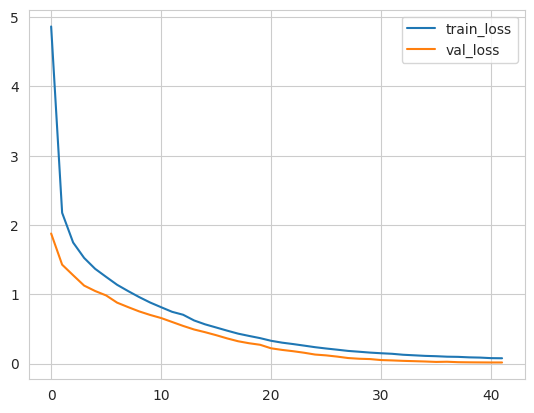

In [ ]:
loss_filepath = "/content/drive/MyDrive/ITMO/T5QA/data/t5_MedQA_generated_loss_42.csv"
# Plot loss
trainer_module.plot_loss(filepath=loss_filepath)

### Inference

In [ ]:
test_sample = test_data.iloc[20]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что такое увеит? также называется: ирит; парспланит; хориоидит; хориоретинит; передний увеит; задний увеит
Контекст: увеит это отек и воспаление сосудистой оболочки глаза. увеа это средний слой стенки глаза. увеа снабжает кровью радужную оболочку в передней части глаза и сетчатку в задней части глаза. причины увеит может быть вызван аутоиммунными заболеваниями. эти заболевания возникают, когда иммунная система организма по ошибке атакует и разрушает здоровые ткани организма. примеры: анкилозирующий спондилит болезнь бехчета псориаз реактивный артрит ревматоидный артрит саркоидоз язвенный колит увеит также может быть вызван такими инфекциями, как: спид цитомегаловирус цмв ретинит опоясывающий лишай гистоплазмоз болезнь кавасаки сифилис токсоплазмоз воздействие токсинов или травмы также могут вызвать увеит. во многих случаях причина неизвестна. часто воспаление ограничивается только частью сосудистой оболочки глаза. наиболее распространенная форма увеита включает воспаление раду

In [ ]:
test_sample = test_data.iloc[18]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос: какие меры вы предпринимаете, чтобы помочь потушить пламя?
Контекст: вот эти шаги: оберните человека плотным материалом; например, шерстяное или хлопковое пальто, ковер или одеяло. это помогает потушить пламя. облейте человека водой. позвоните 911 или по местному номеру службы экстренной помощи. убедитесь, что человек больше не прикасается к горящим или дымящимся материалам. не снимайте обожженную одежду, прилипшую к коже. убедитесь, что человек дышит. при необходимости начните искусственное дыхание и сердечнолегочную реанимацию. накройте место ожога сухой стерильной повязкой при наличии или чистой тканью. лист подойдет, если
Ответ: заверните человека в плотный материал


In [ ]:
test_sample = test_data.iloc[22]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос: какие анализы назначают при метаболическом ацидозе?
Контекст: зависят от основного заболевания или состояния. метаболический ацидоз сам по себе вызывает учащенное и глубокое дыхание, поскольку ваше тело пытается его компенсировать. также могут возникнуть спутанность сознания или вялость. тяжелый метаболический ацидоз может привести к шоку или смерти. симптомы респираторного ацидоза могут включать: спутанность сознания, утомляемость, летаргию, одышку, сонливость, осмотры и анализы. медицинский работник проведет медицинский осмотр и спросит о ваших симптомах. лабораторные анализы, которые могут быть назначены, включают: газы артериальной или венозной крови
Ответ: лабораторные тесты


In [ ]:
test_sample = test_data.iloc[10]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос: как называется нетоксичный ингредиент пенного мыла для ванн?
Контекст: отравление пенным мылом для ванн происходит, когда ктото проглатывает пенное мыло. эта статья предназначена только для информации. не используйте его для лечения или устранения фактического воздействия яда. если вы или ктото, с кем вы находитесь, подверглись воздействию, позвоните по местному номеру службы экстренной помощи например, 911 или в местный токсикологический центр можно связаться напрямую, позвонив на национальную бесплатную горячую линию помощи при отравлениях 18002221222. из любой точки сша. ядовитый ингредиент большинство мыла с пеной для ванн считаются неядовитыми нетоксичными.
Ответ: неядовитый


In [ ]:
test_context = f"Контекст: Холецистит является воспалительным процессом, который возникает в желчном пузыре. От этой патологии сегодня страдает около 20% жителей всего мира. Причем наиболее подвержены заболеванию женщины старше 50 лет. Воспаление выявляют у людей и другого возраста. Причем для детей и подростков характерна бескаменная форма. Зачастую болезнь диагностируется в развитых странах. Обусловлено это особым образом жизни и пищевым поведением."
test_question = f"Вопрос: Что такое холецистит?"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)


Вопрос: Что такое холецистит?
Контекст: Холецистит является воспалительным процессом, который возникает в желчном пузыре. От этой патологии сегодня страдает около 20% жителей всего мира. Причем наиболее подвержены заболеванию женщины старше 50 лет. Воспаление выявляют у людей и другого возраста. Причем для детей и подростков характерна бескаменная форма. Зачастую болезнь диагностируется в развитых странах. Обусловлено это особым образом жизни и пищевым поведением.
Ответ: холецистит
